# Compare Readouts vs bpR2

by Vito Zanotelli
vito.zanotelli@gmail.com

Look at the overlap between using DREMI/Spearman correlatio/Pearson correlation as a cutoff.

The bpR2 was calculated using the adnet/Spearman/Pearson correlatio were calulated using the Adnet script.
The DREMI value was calculated using the reference matlab GUI implementation from the DREMI paper (Conditional density-based analysis of T cell signaling in single-cell data, Science 2014) modified to write out the results as a .csv file.



In [1]:
from  __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np
from matplotlib_venn import venn3, venn3_circles
import bokeh.plotting as bplt
import bokeh.models as bmod
import bokeh as bk
bk.io.output_notebook()
%matplotlib inline  

BokehJS successfully loaded.

Set the file paths

In [2]:
# the bin_dat pickle file, outputed by the adnet analysis script
bin_dat_fn = '/mnt/imls-bod/XiaoKangL/EGF transfection/plots/nbin10_2.5perc_bpr2_median_25_final/t_bindat'
# exported from the matlab dremi gui
dremi_fn = '/home/vitoz/imls-bod/XiaoKangL/EGF transfection/benchmark/20160314_dremi_values_all_overexpressions.csv'
# a dictionary with the old and new names
name_dict = '/home/vitoz/imls-bod/XiaoKangL/EGF transfection/name_dict.csv'
out_folder = '/home/vitoz/Data/Analysis/XKL'
neg_ctrl_names = ['empty-1','empty-2','GFP-FLAG-1','GFP-FLAG-2']

#neg_ctrl_names = ['empty-1','empty-2']


crap_names = ['cleaved PARP-cleaved caspase3', 'cyclin B1', 'p-4EBP1', 'p-HH3', 'p-RB', 'beads']

Load the binned data file

In [3]:
bin_dat = pd.read_pickle(bin_dat_fn)
bin_dat.index.get_level_values('target').unique()


array(['Beta-catenin', 'E-cadherin', 'beads',
       'cleaved PARP-cleaved caspase3', 'cyclin B1', 'p-4EBP1', 'p-AKT',
       'p-AMPKalpha', 'p-BTK', 'p-CREB', 'p-ERK1-2', 'p-FAK',
       'p-GSK3-Beta', 'p-HH3', 'p-JNK', 'p-MAPKAPK2', 'p-MARCKS',
       'p-MEK1-2', 'p-MKK3', 'p-MKK3-6', 'p-NfkB', 'p-PDPK1', 'p-PLCg2',
       'p-RB', 'p-S6', 'p-SHP2', 'p-SMAD1-5', 'p-SMAD2-3', 'p-STAT1',
       'p-STAT3', 'p-STAT5', 'p-mTOR', 'p-p38', 'p-p70S6K', 'p-p90RSK'], dtype=object)

Prepare the name dict


In [4]:
name_dict = pd.read_csv(name_dict)
name_dict = {row['old']: row['new'] for idx, row in name_dict.iterrows()}

Read the DREMI data

In [5]:
dat_dremi = pd.read_csv(dremi_fn, sep=',',index_col=False)
dat_dremi.head()


,origin,target,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B10_cell_SRC-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B11_cell_MAP2K6-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B2_cell_SRC-GFP EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B3_cell_MAP2K6-GFP EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B4_cell_SRC-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B5_cell_MAP2K6-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B6_cell_SRC-GFP EGF 15min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B7_cell_MAP2K6-GFP EGF 15min.fcs,...,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G10_cell_MAP2K7-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G11_cell_Empty-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G2_cell_MAP2K7-GFP EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G3_cell_Empty EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G4_cell_MAP2K7-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G5_cell_Empty-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G6_cell_MAP2K7-GFP EGF 15min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G7_cell_Empty-GFP EGF 15min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G8_cell_MAP2K7-GFP EGF 30min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G9_cell_Empty-GFP EGF 30min.fcs
0,gfp,idu,0.12445,0.001861,0.17874,0.000000,0.11858,0.000000,0.095233,0.000000,...,0.032370,0.22224,0.144480,0.102980,0.137430,0.232220,0.180840,0.078002,0.009091,0.132090
1,gfp,pcreb,0.29583,0.220030,0.19061,0.084494,0.18983,0.192050,0.261740,0.213340,...,0.129090,0.22609,0.108570,0.252460,0.143060,0.224680,0.119310,0.191620,0.130410,0.278740
2,gfp,pstat5,0.50454,0.221740,0.43672,0.217850,0.45457,0.171900,0.559990,0.223150,...,0.237980,0.15508,0.121040,0.119500,0.018499,0.078073,0.060820,0.054951,0.119430,0.104330
3,gfp,pshp2,0.42297,0.153250,0.36183,0.057021,0.28165,0.010023,0.408160,0.062089,...,0.002691,0.15556,0.004671,0.098055,0.018680,0.069710,0.036441,0.121500,0.012267,0.089511
4,gfp,pfak,0.50240,0.127230,0.46869,0.170330,0.41797,0.177040,0.579020,0.107260,...,0.094818,0.13604,0.061195,0.094007,0.035332,0.095992,0.086016,0.106280,0.064840,0.090380


make the name dict compatible with the DREMI names (only alphanumeric, lower case)

In [6]:
name_dict_dremi = dict((filter(str.isalnum, oldname.lower()), nicename) for oldname, nicename in name_dict.iteritems())

In [7]:
dat_dremi['target'] = dat_dremi['target'].map(lambda x: name_dict_dremi[x])

Merge the dremi data with the bpr2 data

In [8]:
dat_dremi_stacked = dat_dremi.copy()
dat_dremi_stacked['origin'] = dat_dremi_stacked['origin'].map(lambda x: x.upper())
dat_dremi_stacked['origin'].map(lambda x: x.upper())
dat_dremi_stacked = dat_dremi_stacked.set_index(['origin','target'])

dat_dremi_stacked =  pd.DataFrame(dat_dremi_stacked.stack(), columns=['dremi'])
dat_dremi_stacked.index.names = ['origin', 'target', 'filename']

# extract experiment and row-col from the filename

get_experiment = lambda x: x.split('/')[5]
get_rowcol = lambda x: x.split('/')[5]
dat_dremi_stacked['experiment'] = [x.split('/')[5] for x in dat_dremi_stacked.index.get_level_values('filename')]
dat_dremi_stacked['row_col'] = [x.split('_')[1] for x in dat_dremi_stacked.index.get_level_values('filename')]

dat_dremi_stacked = dat_dremi_stacked.reset_index('filename', drop=True)
dat_dremi_stacked = dat_dremi_stacked.reset_index()

#pd.merge(bin_dat, dat_dremi_stacked, left_index=['origin', 'target', 'row_col', 'experiment'], right_index=['origin', 'target', 'row_col', 'experiment'])

t_dat = bin_dat.reset_index()
t_dat = t_dat[bin_dat.index.names]
t_dat.columns = t_dat.columns.get_level_values(0)
dat_dremi_stacked = pd.merge(t_dat, dat_dremi_stacked, how='outer')

# due to the way the merging was performed, both bindat and dat_dremi are now aligned

dat_dremi_stacked = dat_dremi_stacked.dropna(subset=['marker'])
bin_dat[('stats', 'dremi')] = dat_dremi_stacked['dremi'].tolist()



Calculate the dremi median over the replicates

In [9]:
bin_dat[('stats', 'dremi_median')] = bin_dat[('stats', 'dremi')].groupby(level=['marker', 'origin', 'target', 'timepoint','perturbation']).transform(np.median)

Prepare the negative control filter

In [10]:
bin_dat = bin_dat.loc[bin_dat.index.get_level_values('target').isin(crap_names) == False, :]
neg_mark_fil = bin_dat.index.get_level_values('marker').isin(neg_ctrl_names)

Filter out the non wanted markers

### Start the comparison


Look only at timepoint 0

In [11]:
#fil = [ x not in filtarget for x in bin_dat.index.get_level_values('target')]
fil = [ x ==0  for x in bin_dat.index.get_level_values('timepoint')]
bin_dat = bin_dat.loc[fil]
neg_mark_fil = np.array([negmark for negmark, f in zip(neg_mark_fil, fil) if f])
bin_dat.loc[neg_mark_fil == False].index.get_level_values('marker').unique()

array(['AKT1', 'CRAF', 'GSK3B', 'MAP2K1', 'MAP2K6', 'MAPK1', 'MAPK14',
       'PDPK1', 'RPS6KA1', 'SRC', 'MAP2K7', 'BRAF', 'HRAS', 'KRAS',
       'MAP3K5', 'MAP8', 'PIK3CA', 'PTPN11', 'RPS6', 'RPS6KB1'], dtype=object)

Calculate the cutoffs using the negative control for dremi, bpr2 and spearman

0.59273
0.24315
0.24315
53.0
0.2306
61.0


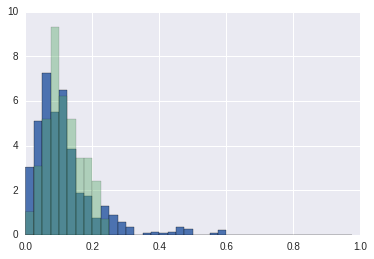

In [12]:
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_dremi = bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].max()
maxneg_dremi_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].dropna(),99,)
maxneg_dremi_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].dropna(),90,)
print(bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].max())

print(maxneg_dremi)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')] > maxneg_dremi)/3)
print(maxneg_dremi_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')] > maxneg_dremi_99)/3)

0.60043307503
0.092084973206
0.092084973206
84.0
0.0812704533868
95.0


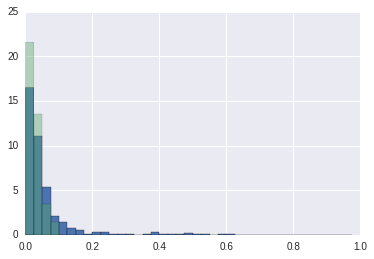

In [13]:
bin_dat['stats']
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_bp = bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].max()
maxneg_bp_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].dropna(),99)
maxneg_bp_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].dropna(),90)

print(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].max())

print(maxneg_bp)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')] > maxneg_bp)/3)
print(maxneg_bp_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')] > maxneg_bp_99)/3)


In [14]:
maxneg_bp_99

0.081270453386769234

0.872379147208
0.298844057743
0.298844057743
86.0
0.0812704533868
101.0


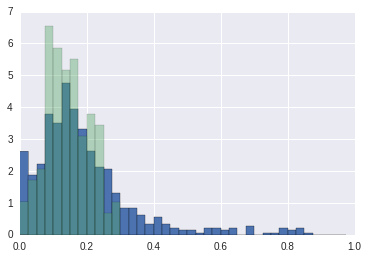

In [15]:
bin_dat['stats']
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_sp = bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].max()
maxneg_sp_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].dropna(),99,)
maxneg_sp_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].dropna(),90,)
print(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].max())

print(maxneg_sp)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')] > maxneg_sp)/3)
print(maxneg_bp_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')] > maxneg_sp_99)/3)


0.902864409007
0.352638354144
0.352638354144
83.0
0.310341117
97.0


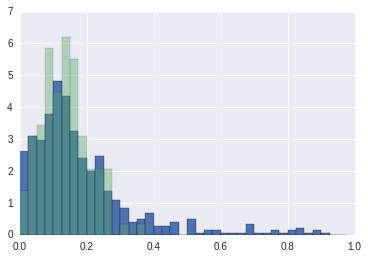

In [16]:
bin_dat['stats']
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_pc = bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].max()
maxneg_pc_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].dropna(),99,)
maxneg_pc_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].dropna(),90,)
print(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].max())

print(maxneg_pc)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')] > maxneg_sp)/3)
print(maxneg_pc_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')] > maxneg_sp_99)/3)


In [17]:
#fil = bin_dat[('stats', 'dremi_median')] > 0.24
#fildat = bin_dat.loc[(fil) & (neg_mark_fil)]
#hits_dremi_GFP = set('_'.join([m, t, str(tp)]) for m, t, tp in
#             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))
#hits_dremi_GFP

Compare the overlap of hits between 

In [18]:
fil = bin_dat[('stats', 'dremi_median')] > maxneg_dremi_99
fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_dremi = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

fil = bin_dat[('stats', 'median_mean_var_ratio')] > maxneg_bp_99
fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_bp = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

fil = bin_dat[('stats', 'median_abs_corr_spearman_overall')] > maxneg_sp_99

fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_sp = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

fil = bin_dat[('stats', 'median_abs_corr_pearson_overall')] > maxneg_pc_99

fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_pc = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

Look at the different hits as a venn diagramm

<matplotlib_venn._common.VennDiagram instance at 0x7fe7111bdc68>

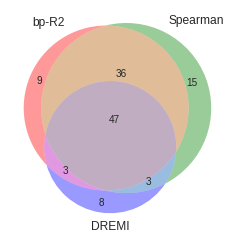

In [19]:

venn3([hits_bp,hits_sp,hits_dremi],set_labels=['bp-R2', 'Spearman', 'DREMI'])

#plt.savefig(os.path.join(out_folder,'20160429_readout_comparison_venn_wocc.pdf'))

<matplotlib_venn._common.VennDiagram instance at 0x7fe711110a28>

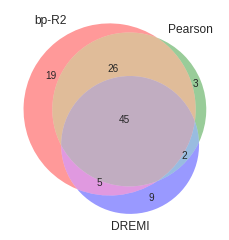

In [20]:
venn3([hits_bp,hits_pc,hits_dremi],set_labels=['bp-R2', 'Pearson', 'DREMI'])

## Look how exactly the hits differ

In [21]:
hits_bp

{'AKT1_Beta-catenin_0',
 'AKT1_p-AKT_0',
 'AKT1_p-BTK_0',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-MKK3-6_0',
 'AKT1_p-PDPK1_0',
 'AKT1_p-SMAD1-5_0',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-p70S6K_0',
 'BRAF_p-MKK3-6_0',
 'BRAF_p-S6_0',
 'BRAF_p-SMAD1-5_0',
 'CRAF_p-JNK_0',
 'CRAF_p-p90RSK_0',
 'GSK3B_Beta-catenin_0',
 'GSK3B_p-FAK_0',
 'GSK3B_p-GSK3-Beta_0',
 'GSK3B_p-MEK1-2_0',
 'GSK3B_p-MKK3_0',
 'GSK3B_p-PDPK1_0',
 'GSK3B_p-SHP2_0',
 'GSK3B_p-STAT1_0',
 'GSK3B_p-STAT5_0',
 'GSK3B_p-p70S6K_0',
 'HRAS_p-JNK_0',
 'HRAS_p-SMAD1-5_0',
 'HRAS_p-SMAD2-3_0',
 'MAP2K1_Beta-catenin_0',
 'MAP2K1_p-BTK_0',
 'MAP2K1_p-GSK3-Beta_0',
 'MAP2K1_p-MEK1-2_0',
 'MAP2K1_p-MKK3-6_0',
 'MAP2K1_p-SMAD2-3_0',
 'MAP2K1_p-STAT5_0',
 'MAP2K6_p-GSK3-Beta_0',
 'MAP2K6_p-MKK3-6_0',
 'MAP2K6_p-SMAD1-5_0',
 'MAP2K6_p-STAT1_0',
 'MAP2K6_p-STAT5_0',
 'MAP2K6_p-p38_0',
 'MAP2K7_p-SMAD1-5_0',
 'MAP3K5_p-AMPKalpha_0',
 'MAP3K5_p-GSK3-Beta_0',
 'MAP3K5_p-JNK_0',
 'MAP3K5_p-MAPKAPK2_0',
 'MAP3K5_p-MKK3-6_0',
 'MAP3K5_p-MKK3_0',
 'MAP3K5_p-

In [22]:
hits_bp.difference(hits_dremi)

{'AKT1_Beta-catenin_0',
 'AKT1_p-BTK_0',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-MKK3-6_0',
 'AKT1_p-PDPK1_0',
 'AKT1_p-SMAD1-5_0',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-p70S6K_0',
 'BRAF_p-MKK3-6_0',
 'CRAF_p-JNK_0',
 'CRAF_p-p90RSK_0',
 'GSK3B_Beta-catenin_0',
 'GSK3B_p-FAK_0',
 'GSK3B_p-MEK1-2_0',
 'GSK3B_p-PDPK1_0',
 'GSK3B_p-SHP2_0',
 'GSK3B_p-STAT5_0',
 'GSK3B_p-p70S6K_0',
 'HRAS_p-JNK_0',
 'HRAS_p-SMAD1-5_0',
 'HRAS_p-SMAD2-3_0',
 'MAP2K1_p-BTK_0',
 'MAP2K1_p-GSK3-Beta_0',
 'MAP2K6_p-GSK3-Beta_0',
 'MAP2K6_p-STAT1_0',
 'MAP2K7_p-SMAD1-5_0',
 'MAP3K5_p-MKK3_0',
 'MAP3K5_p-PDPK1_0',
 'MAP3K5_p-SMAD2-3_0',
 'MAP3K5_p-STAT1_0',
 'MAP8_p-PDPK1_0',
 'MAP8_p-p70S6K_0',
 'MAPK1_p-ERK1-2_0',
 'MAPK1_p-p38_0',
 'PDPK1_p-BTK_0',
 'PDPK1_p-S6_0',
 'PIK3CA_p-JNK_0',
 'PIK3CA_p-MKK3-6_0',
 'PIK3CA_p-SMAD1-5_0',
 'PIK3CA_p-STAT1_0',
 'PIK3CA_p-p38_0',
 'PTPN11_p-JNK_0',
 'RPS6KA1_p-PDPK1_0',
 'SRC_p-JNK_0',
 'SRC_p-SMAD1-5_0'}

In [23]:


hits_bp.difference(hits_dremi.union(hits_sp))

{'AKT1_Beta-catenin_0',
 'AKT1_p-BTK_0',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-SMAD2-3_0',
 'GSK3B_p-FAK_0',
 'MAP2K1_p-BTK_0',
 'MAP2K1_p-GSK3-Beta_0',
 'MAP2K6_p-GSK3-Beta_0',
 'PIK3CA_p-STAT1_0'}

In [24]:
hits_bp.difference(hits_sp)

{'AKT1_Beta-catenin_0',
 'AKT1_p-BTK_0',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-SMAD2-3_0',
 'BRAF_p-S6_0',
 'GSK3B_p-FAK_0',
 'MAP2K1_Beta-catenin_0',
 'MAP2K1_p-BTK_0',
 'MAP2K1_p-GSK3-Beta_0',
 'MAP2K1_p-MKK3-6_0',
 'MAP2K6_p-GSK3-Beta_0',
 'PIK3CA_p-STAT1_0'}

In [25]:
hits_dremi.difference(hits_bp)


{'AKT1_p-S6_0',
 'MAP2K1_p-S6_0',
 'MAP2K6_Beta-catenin_0',
 'MAP2K6_p-S6_0',
 'MAP3K5_Beta-catenin_0',
 'MAP8_p-PLCg2_0',
 'MAP8_p-STAT3_0',
 'PDPK1_p-AKT_0',
 'PTPN11_p-CREB_0',
 'PTPN11_p-MARCKS_0',
 'SRC_Beta-catenin_0'}

In [26]:
hits_dremi.difference(hits_bp.union(hits_sp))

{'AKT1_p-S6_0',
 'MAP2K1_p-S6_0',
 'MAP2K6_Beta-catenin_0',
 'MAP2K6_p-S6_0',
 'MAP3K5_Beta-catenin_0',
 'PDPK1_p-AKT_0',
 'PTPN11_p-CREB_0',
 'SRC_Beta-catenin_0'}

In [27]:
hits_dremi.difference(hits_sp)

{'AKT1_p-S6_0',
 'BRAF_p-S6_0',
 'MAP2K1_Beta-catenin_0',
 'MAP2K1_p-MKK3-6_0',
 'MAP2K1_p-S6_0',
 'MAP2K6_Beta-catenin_0',
 'MAP2K6_p-S6_0',
 'MAP3K5_Beta-catenin_0',
 'PDPK1_p-AKT_0',
 'PTPN11_p-CREB_0',
 'SRC_Beta-catenin_0'}

In [28]:
hits_sp.difference(hits_bp)

{'AKT1_p-STAT5_0',
 'BRAF_p-JNK_0',
 'CRAF_p-ERK1-2_0',
 'HRAS_p-p38_0',
 'MAP2K7_p-STAT5_0',
 'MAP3K5_p-p70S6K_0',
 'MAP8_p-PLCg2_0',
 'MAP8_p-SMAD2-3_0',
 'MAP8_p-STAT3_0',
 'MAP8_p-STAT5_0',
 'MAPK1_p-JNK_0',
 'PIK3CA_Beta-catenin_0',
 'PIK3CA_p-GSK3-Beta_0',
 'PIK3CA_p-PLCg2_0',
 'PIK3CA_p-SMAD2-3_0',
 'PTPN11_p-MARCKS_0',
 'RPS6KA1_p-SHP2_0',
 'RPS6KA1_p-STAT5_0'}

In [29]:
hits_sp.difference(hits_bp.union(hits_dremi))

{'AKT1_p-STAT5_0',
 'BRAF_p-JNK_0',
 'CRAF_p-ERK1-2_0',
 'HRAS_p-p38_0',
 'MAP2K7_p-STAT5_0',
 'MAP3K5_p-p70S6K_0',
 'MAP8_p-SMAD2-3_0',
 'MAP8_p-STAT5_0',
 'MAPK1_p-JNK_0',
 'PIK3CA_Beta-catenin_0',
 'PIK3CA_p-GSK3-Beta_0',
 'PIK3CA_p-PLCg2_0',
 'PIK3CA_p-SMAD2-3_0',
 'RPS6KA1_p-SHP2_0',
 'RPS6KA1_p-STAT5_0'}

In [30]:
hits_bp.union(hits_sp).difference(hits_dremi)

{'AKT1_Beta-catenin_0',
 'AKT1_p-BTK_0',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-MKK3-6_0',
 'AKT1_p-PDPK1_0',
 'AKT1_p-SMAD1-5_0',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-STAT5_0',
 'AKT1_p-p70S6K_0',
 'BRAF_p-JNK_0',
 'BRAF_p-MKK3-6_0',
 'CRAF_p-ERK1-2_0',
 'CRAF_p-JNK_0',
 'CRAF_p-p90RSK_0',
 'GSK3B_Beta-catenin_0',
 'GSK3B_p-FAK_0',
 'GSK3B_p-MEK1-2_0',
 'GSK3B_p-PDPK1_0',
 'GSK3B_p-SHP2_0',
 'GSK3B_p-STAT5_0',
 'GSK3B_p-p70S6K_0',
 'HRAS_p-JNK_0',
 'HRAS_p-SMAD1-5_0',
 'HRAS_p-SMAD2-3_0',
 'HRAS_p-p38_0',
 'MAP2K1_p-BTK_0',
 'MAP2K1_p-GSK3-Beta_0',
 'MAP2K6_p-GSK3-Beta_0',
 'MAP2K6_p-STAT1_0',
 'MAP2K7_p-SMAD1-5_0',
 'MAP2K7_p-STAT5_0',
 'MAP3K5_p-MKK3_0',
 'MAP3K5_p-PDPK1_0',
 'MAP3K5_p-SMAD2-3_0',
 'MAP3K5_p-STAT1_0',
 'MAP3K5_p-p70S6K_0',
 'MAP8_p-PDPK1_0',
 'MAP8_p-SMAD2-3_0',
 'MAP8_p-STAT5_0',
 'MAP8_p-p70S6K_0',
 'MAPK1_p-ERK1-2_0',
 'MAPK1_p-JNK_0',
 'MAPK1_p-p38_0',
 'PDPK1_p-BTK_0',
 'PDPK1_p-S6_0',
 'PIK3CA_Beta-catenin_0',
 'PIK3CA_p-GSK3-Beta_0',
 'PIK3CA_p-JNK_0',
 'PIK3CA_p-MKK3-6_0'

In [31]:
hits_bp.intersection(hits_dremi).difference(hits_sp)

{'BRAF_p-S6_0', 'MAP2K1_Beta-catenin_0', 'MAP2K1_p-MKK3-6_0'}

## Make a table of the hits and save it 

In [32]:
hit_dict = dict()

hit_dict['all_hits'] = list(set(list(hits_sp)+ list(hits_dremi)+ list(hits_bp)))
hit_dict['is_bp'] = [h in hits_bp for h in hit_dict['all_hits'] ]
hit_dict['is_sp'] = [h in hits_sp for h in hit_dict['all_hits'] ]
hit_dict['is_dremi'] = [h in hits_dremi for h in hit_dict['all_hits'] ]


hit_tab = pd.DataFrame.from_dict(hit_dict)
#hit_tab = hit_tab.set_index('all_hits')

hit_tab = hit_tab.sort_values(by=['is_bp','is_dremi', 'is_sp'],ascending=False)

hit_tab.to_csv(os.path.join(out_folder,'20160429_readout_comparison_vsemptygfp_woCC.csv'),index=False)

In [33]:
hit_tab

,all_hits,is_bp,is_dremi,is_sp
0,RPS6KB1_p-S6_0,True,True,True
7,MAP8_p-JNK_0,True,True,True
12,MAP2K6_p-STAT5_0,True,True,True
15,BRAF_p-SMAD1-5_0,True,True,True
16,RPS6KA1_p-BTK_0,True,True,True
17,MAPK14_p-p38_0,True,True,True
19,PTPN11_p-SMAD1-5_0,True,True,True
23,AKT1_p-AKT_0,True,True,True
30,PDPK1_p-PDPK1_0,True,True,True
32,MAP3K5_p-MAPKAPK2_0,True,True,True


In [34]:
#bin_dat.plot(kind='scatter', x=('stats', 'mean_var_ratio'), y=('stats', 'dremi'))



def draw_tooltip_scatter(df, x, y, plot_width=400, plot_height=400, pointsize=8, title='Title'):
    source = bplt.ColumnDataSource(data=dict([
        ('idx', bin_dat.index.tolist()),
        ('x',df[x]),
        ('y',df[y])]
        ))

    hover = bmod.HoverTool(
            tooltips=[
                ("idx", "@idx"),
            ("(x,y)", "($x, $y)")
            ]
        )

    p = bplt.figure(plot_width=plot_width, plot_height=plot_height, 
               title=title,
                   x_axis_label=str(x), y_axis_label=str(y))
    p.add_tools(hover)

    p.circle('x','y', size=pointsize, source=source)
    bplt.show(p)
    return p

xcol =('stats', 'mean_var_ratio')
ycol = ('stats', 'dremi')

draw_tooltip_scatter(bin_dat,xcol, ycol )

In [35]:
#bin_dat.plot(kind='scatter', x=('stats', 'median_mean_var_ratio'), y=('stats', 'median_abs_corr_spearman_overall'))

xcol =('stats', 'mean_var_ratio')
ycol = ('stats', 'corr_spearman_overall')
draw_tooltip_scatter(bin_dat,xcol, ycol )

In [36]:
#bin_dat.plot(kind='scatter', x=('stats', 'median_mean_var_ratio'), y=('stats', 'median_abs_corr_spearman_overall'))

xcol =('stats', 'mean_var_ratio')
ycol = ('stats', 'corr_pearson_overall')
draw_tooltip_scatter(bin_dat,xcol, ycol )

Compare different bins

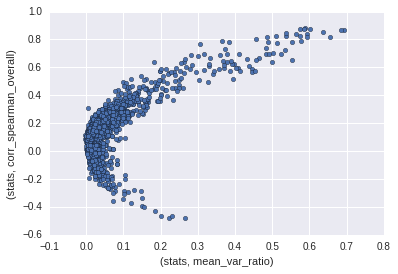

In [37]:
bin_dat.plot(kind='scatter', x=('stats', 'mean_var_ratio'), y=('stats', 'corr_spearman_overall'))

In [38]:
fil = (bin_dat[('stats', 'median_mean_var_ratio')] < 0.5) & \
    (bin_dat[('stats', 'median_mean_var_ratio')] > 0.4) & (bin_dat[('stats', 'median_abs_corr_spearman_overall')] <0.4)
    
bin_dat.loc[fil]

Empty DataFrame
Columns: [(counts, 0), (counts, 1), (counts, 2), (counts, 3), (counts, 4), (counts, 5), (counts, 6), (counts, 7), (counts, 8), (counts, 9), (fit_var, 0), (fit_var, 1), (fit_var, 2), (fit_var, 3), (fit_var, 4), (fit_var, 5), (fit_var, 6), (fit_var, 7), (fit_var, 8), (fit_var, 9), (median, 0), (median, 1), (median, 2), (median, 3), (median, 4), (median, 5), (median, 6), (median, 7), (median, 8), (median, 9), (overall_var, 0), (overall_var, 1), (overall_var, 2), (overall_var, 3), (overall_var, 4), (overall_var, 5), (overall_var, 6), (overall_var, 7), (overall_var, 8), (overall_var, 9), (var_ratio, 0), (var_ratio, 1), (var_ratio, 2), (var_ratio, 3), (var_ratio, 4), (var_ratio, 5), (var_ratio, 6), (var_ratio, 7), (var_ratio, 8), (var_ratio, 9), (stats, mean_var_ratio), (stats, mean_mean_var_ratio), (stats, median_mean_var_ratio), (stats, nr_rep), (stats, corr_pearson_overall), (stats, corr_spearman_overall), (stats, median_corr_pearson_overall), (stats, median_corr_spearman_overall), (stats, median_abs_corr_pearson_overall), (stats, median_abs_corr_spearman_overall), (stats, corr_pearson_bin), (stats, corr_spearman_bin), (bin_dat_sigfil, ), (bin_dat_sigfil_any, ), (bin_dat_sigfil_any_rep, ), (stats, is_median_varratio), (stats, dremi), (stats, dremi_median)]
Index: []

[0 rows x 68 columns]

In [39]:
bin_dat.xs('p-GSK3-Beta', level='target').xs('MAP2K6', level='marker')['stats'].columns

Index([u'mean_var_ratio', u'mean_mean_var_ratio', u'median_mean_var_ratio',
       u'nr_rep', u'corr_pearson_overall', u'corr_spearman_overall',
       u'median_corr_pearson_overall', u'median_corr_spearman_overall',
       u'median_abs_corr_pearson_overall', u'median_abs_corr_spearman_overall',
       u'corr_pearson_bin', u'corr_spearman_bin', u'is_median_varratio',
       u'dremi', u'dremi_median'],
      dtype='object', name=u'bin')

In [40]:
np.median(1-(bin_dat.xs('p-GSK3-Beta', level='target').xs('MAP2K6', level='marker')['fit_var']/
   bin_dat.xs('p-GSK3-Beta', level='target').xs('MAP2K6', level='marker')[u'overall_var']), axis=1)

array([ 0.05996865,  0.06136547,  0.00816118])

In [41]:
print(bin_dat.index.get_level_values('target').unique())
print(bin_dat.index.get_level_values('marker').unique())

['Beta-catenin' 'E-cadherin' 'p-AKT' 'p-AMPKalpha' 'p-BTK' 'p-CREB'
 'p-ERK1-2' 'p-FAK' 'p-GSK3-Beta' 'p-JNK' 'p-MAPKAPK2' 'p-MARCKS'
 'p-MEK1-2' 'p-MKK3' 'p-MKK3-6' 'p-NfkB' 'p-PDPK1' 'p-PLCg2' 'p-S6'
 'p-SHP2' 'p-SMAD1-5' 'p-SMAD2-3' 'p-STAT1' 'p-STAT3' 'p-STAT5' 'p-mTOR'
 'p-p38' 'p-p70S6K' 'p-p90RSK']
['AKT1' 'CRAF' 'GFP-FLAG-1' 'GSK3B' 'MAP2K1' 'MAP2K6' 'MAPK1' 'MAPK14'
 'PDPK1' 'RPS6KA1' 'SRC' 'empty-1' 'MAP2K7' 'BRAF' 'GFP-FLAG-2' 'HRAS'
 'KRAS' 'MAP3K5' 'MAP8' 'PIK3CA' 'PTPN11' 'RPS6' 'RPS6KB1' 'empty-2']
